In [566]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sys
import evaluation

In [567]:
BASE_RESULTS_DIR = "../results"
DATASETS = ["movielens-1m", "bikeshare", "epinions"]
EXPERIMENT_TITLES = {
    "movielens-1m_online": "MovieLens-Fixed",
    "movielens-1m_time_series": "MovieLens-TimeSeries",
    "bikeshare_time_series": "BikeShare",
    "selected": "Epinions",
}
EVALUATOR_NAME = {
    "movielens-1m_online": "RMSE",
    "movielens-1m_time_series": "RMSE",
    "bikeshare_time_series": "Correlation",
    "selected": "F1",
}
REGRET_FREE_METHOD = {
    "POWERSET": True,
    "NON_POWERSET": False,
    "SGD_TI": True
}
PSL_VERSIONS = ["offline", "online"]
EXPERIMENTS = {
    "movielens-1m": ["movielens-1m_online", "movielens-1m_time_series"],
    "epinions": ["selected"],
    "bikeshare": ["bikeshare_time_series"],
}
EXPERIMENT_YLIMS = {
    "movielens-1m_online": [0, 0.01],
    "movielens-1m_time_series": [0, 0.1],
    "bikeshare_time_series": [0, 0.01],
    "selected": [0, 1]
}
PSL_VERSION_METHODS = {
    "online": ["NON_POWERSET", "POWERSET"],
    "offline": ["SGD_TI"]
}
INITIALIZATION = ["ATOM", "RANDOM"]
EVALUATORS = {
    "movielens-1m": evaluation.rmse,
    "epinions": evaluation.f1,
    "bikeshare": evaluation.pearson_correlation
}
INFERRED_FILE_NAME = {
    "movielens-1m": "RATING.txt",
    "epinions": "TRUSTS.txt",
    "bikeshare": "DEMAND.txt"
}
TRUTH_FILE_NAME = {
    "movielens-1m": "rating_truth.txt",
    "epinions": "trusts_truth.txt",
    "bikeshare": "Demand_truth.txt"
}

# Parsing keywords
ONLINE_INFERENCE_START_KEYWORD = "Optimization Start"
ONLINE_INFERENCE_END_KEYWORD = "Optimization End"
ONLINE_INFERENCE_WRITE_KEYWORD = "Writing inferred predicates to file:"
OFFLINE_INFERENCE_START_KEYWORD = "Beginning inference."
OFFLINE_INFERENCE_END_KEYWORD = "Inference Complete"
ALPHA_MIN = "Alpha min"
BETA_MAX = "Beta max"
BETA_AVG = "Beta average"
BETAS = "Observed rates of change of gradients (Beta)"
L_MAX = "L max"
L_AVG = "L average"
REGRET_OBJECTIVE_KEYWORD = "Initial Objective:"
REGRET_NORM_OBJECTIVE_KEYWORD = "Initial Normalized Objective:"
VAR_MOVEMENT = "- Movement of variables from initial state"
VAR_DELTA = "variable delta"
INTIAL_GRADIENT = "Initial observed magnitude of gradient"
DELTA_MODEL_GRAD_MAG = "Delta model change in gradient:"
APPROX_DELTA_MODEL = "Approximation Delta Model Gradient Magnitude"
FINAL_OBJ = "Final Normalized Objective:"
FINAL_NORM_OBJ = "Final Normalized Objective:"

# Parse Logs

In [568]:
def get_predicates(predicates_file):
    predicates = pd.read_csv(predicates_file, header=None, sep="\t")
    return predicates.set_index(predicates.columns[:-1].values.tolist())

In [569]:
def read_out_server(out_server_file_path, dataset, experiment, fold, regret_run_dir, approx_delta_model_run_dir, regret_free):
    time_step = 0
    time_step_done = False
    out_server_df = pd.DataFrame()
    with open(out_server_file_path, 'r') as out_server_file:
        for line in out_server_file:
            
            # Parse Timing
            if ONLINE_INFERENCE_START_KEYWORD in line:
                time_step_start_time = line.strip().split()[0]
        
            if ONLINE_INFERENCE_END_KEYWORD in line:
                time_step_end_time = line.strip().split()[0]
                time_step_done = True
                
            # Parse Model Properties
            if ALPHA_MIN in line:
                alpha_min = line.strip().split()[-1]
                
            if BETA_MAX in line:
                beta_max = line.strip().split()[-1]
                
            if BETA_AVG in line:
                beta_avg = line.strip().split()[-1]
            
            if BETAS in line:
                betas = np.array(eval(line.strip().split(':')[-1]))
                
            if L_MAX in line:
                l_max = line.strip().split()[-1]
            
            if L_AVG in line:
                l_avg = line.strip().split()[-1]
                
            if VAR_MOVEMENT in line:
                var_movement = line.strip().split()[-1]
            
            if VAR_DELTA in line:
                var_delta = line.strip().split()[-1]

            if INTIAL_GRADIENT in line:
                initial_gradient = line.strip().split()[-1]
                
            if DELTA_MODEL_GRAD_MAG in line:
                delta_model_grad_mag = line.strip().split()[-1]
            
            if FINAL_OBJ in line:
                final_obj = line.strip().split()[-9].strip(',')
                
            if FINAL_NORM_OBJ in line:
                final_norm_obj = line.strip().split()[-5].strip(',')
            
            if time_step_done:
                # Find number of inferred predicates from inferred predicates file.
                num_inferred = get_predicates(os.path.join(os.path.dirname(out_server_file_path), 
                                 "inferred-predicates", str(time_step).zfill(2), INFERRED_FILE_NAME[dataset])).shape[0]
                
                # Find inferred predicates evaluation for experiment.
                inferred_predicates = get_predicates(
                    os.path.join(os.path.dirname(out_server_file_path), 
                                 "inferred-predicates", str(time_step).zfill(2), INFERRED_FILE_NAME[dataset]))
                
                truth_predicates = get_predicates(
                    os.path.join("/scratch/charles/online-psl-experiments/online-psl-examples", 
                                 dataset, "data", dataset, experiment, str(fold).zfill(2), 
                                 "eval", str(time_step).zfill(2), TRUTH_FILE_NAME[dataset]))
                
                inferred_predicates = inferred_predicates.reindex(truth_predicates.index)
                evaluation = EVALUATORS[dataset](inferred_predicates.iloc[:, 0].values, 
                                                 truth_predicates.iloc[:, 0].values)
                
                # Calculate inferred predicates regret and objective for experiment
                if regret_free:
                    regret = 0
                    approx_delta_model_grad_mag = 0
                    full_obj = final_obj
                    full_norm_obj = final_norm_obj
                else:
                    regret = 0
                    full_obj = 0
                    full_norm_obj = 0
                    with open(os.path.join(regret_run_dir, str(time_step).zfill(2), "out.txt"), 'r') as out_regret_file:
                        for line in out_regret_file:
                            # Parse Regret Calculation
                            if REGRET_OBJECTIVE_KEYWORD in line:
                                full_obj = line.strip().split(':')[1]
                            # Parse Regret Calculation    
                            if REGRET_NORM_OBJECTIVE_KEYWORD in line:
                                full_norm_obj = line.strip().split(':')[1]
                                
                    with open(os.path.join(approx_delta_model_run_dir, "out_server.txt"), 'r') as out_regret_file:
                        count = 0
                        for line in out_regret_file:
                            if APPROX_DELTA_MODEL in line:
                                approx_delta_model_grad_mag = line.strip().split()[-1]
                                if count == time_step:
                                    break
                                else:
                                    count += 1
                
                out_server_df = out_server_df.append(pd.Series(
                    {
                        "alpha_min": alpha_min,
                        "beta_max": beta_max,
                        "beta_avg": betas.mean(),
                        "delta_model_grad_mag": delta_model_grad_mag,
                        "approx_delta_model_grad_mag": approx_delta_model_grad_mag,
                        "evaluation": evaluation,
                        "final_obj": final_obj,
                        "final_norm_obj": final_norm_obj,
                        "full_obj": full_obj,
                        "full_norm_obj": full_norm_obj,
                        "initial_gradient": initial_gradient,
                        "l_avg": l_avg,
                        "l_max": l_max,
                        "num_inferred": num_inferred,
                        "time_step": time_step, 
                        "time": int(time_step_end_time) - int(time_step_start_time),
                        "var_movement": var_movement,
                        "var_delta": var_delta
                    }), ignore_index=True)
                time_step += 1
                time_step_done = False
    
    return out_server_df

def read_out_template_modification_server(out_server_file_path, dataset, experiment, fold, regret_run_dir, approx_delta_model_run_dir, regret_free):
    time_step_done = False
    out_server_df = pd.DataFrame()
    with open(out_server_file_path, 'r') as out_server_file:
        for line in out_server_file:
            
            # Parse Timing
            if ONLINE_INFERENCE_START_KEYWORD in line:
                time_step_start_time = line.strip().split()[0]
        
            if ONLINE_INFERENCE_WRITE_KEYWORD in line:
                time_step_end_time = line.strip().split()[0]
                time_step = line.strip().split()[-1].split('/')[-1]
                if time_step == "inferred-predicates":
                    break
                time_step_done = True
                
                
            # Parse Model Properties
            if ALPHA_MIN in line:
                alpha_min = line.strip().split()[-1]
                
            if BETA_MAX in line:
                beta_max = line.strip().split()[-1]
                
            if BETA_AVG in line:
                beta_avg = line.strip().split()[-1]
                
            if BETAS in line:
                betas = np.array(eval(line.strip().split(':')[-1]))
                
            if L_MAX in line:
                l_max = line.strip().split()[-1]
            
            if L_AVG in line:
                l_avg = line.strip().split()[-1]
                
            if VAR_MOVEMENT in line:
                var_movement = line.strip().split()[-1]
            
            if VAR_DELTA in line:
                var_delta = line.strip().split()[-1]

            if INTIAL_GRADIENT in line:
                initial_gradient = line.strip().split()[-1]
                
            if DELTA_MODEL_GRAD_MAG in line:
                delta_model_grad_mag = line.strip().split()[-1]
            
            if FINAL_OBJ in line:
                final_obj = line.strip().split()[-9].strip(',')
            
            if FINAL_NORM_OBJ in line:
                final_norm_obj = line.strip().split()[-5].strip(',')
            
            if time_step_done:
                # Find number of inferred predicates from inferred predicates file.
                num_inferred = get_predicates(os.path.join(os.path.dirname(out_server_file_path), 
                                 "inferred-predicates", time_step, INFERRED_FILE_NAME[dataset])).shape[0]
                
                # Find inferred predicates evaluation for experiment.
                inferred_predicates = get_predicates(
                    os.path.join(os.path.dirname(out_server_file_path), 
                                 "inferred-predicates", time_step, INFERRED_FILE_NAME[dataset]))
                
                truth_predicates = get_predicates(
                    os.path.join("/scratch/charles/online-psl-experiments/online-psl-examples", 
                                 dataset, "data", dataset, str(fold), "eval", TRUTH_FILE_NAME[dataset]))
                
                inferred_predicates = inferred_predicates.reindex(truth_predicates.index)
                evaluation = EVALUATORS[dataset](inferred_predicates.iloc[:, 0].values, 
                                                 truth_predicates.iloc[:, 0].values, 0.5)
                
                # Calculate inferred predicates regret an objective for experiment
                if regret_free:
                    regret = 0
                    full_obj = final_obj
                    full_norm_obj = final_norm_obj
                else:
                    regret = 0
                    full_obj = 0
                    full_norm_obj = 0
                    with open(os.path.join(regret_run_dir, str(time_step).zfill(2), "out.txt"), 'r') as out_regret_file:
                        for line in out_regret_file:
                            # Parse Regret Calculation
                            if REGRET_OBJECTIVE_KEYWORD in line:
                                full_obj = line.strip().split(':')[1]
                            # Parse Regret Calculation    
                            if REGRET_NORM_OBJECTIVE_KEYWORD in line:
                                full_norm_obj = line.strip().split(':')[1]
                    
                    with open(os.path.join(approx_delta_model_run_dir, "out_server.txt"), 'r') as out_regret_file:
                        count = 0
                        for line in out_regret_file:
                            if APPROX_DELTA_MODEL in line:
                                approx_delta_model_grad_mag = line.strip().split()[-1]
                                if count == time_step:
                                    break
                                else:
                                    count += 1                    
                
                out_server_df = out_server_df.append(pd.Series(
                    {
                        "alpha_min": alpha_min,
                        "beta_max": beta_max,
                        "beta_avg": betas.mean(),
                        "delta_model_grad_mag": delta_model_grad_mag,
                        "approx_delta_model_grad_mag": approx_delta_model_grad_mag,                        
                        "evaluation": evaluation,
                        "final_obj": final_obj,
                        "final_norm_obj": final_norm_obj,
                        "full_obj": full_obj,
                        "full_norm_obj": full_norm_obj,
                        "initial_gradient": initial_gradient,
                        "l_avg": l_avg,
                        "l_max": l_max,
                        "num_inferred": num_inferred,
                        "time_step": time_step, 
                        "time": int(time_step_end_time) - int(time_step_start_time),
                        "var_movement": var_movement,
                        "var_delta": var_delta
                    }), ignore_index=True)
                time_step_done = False
    
    return out_server_df

In [570]:
# Online
def make_online_run_csvs():
    # Movielens and Bikeshare
    for dataset in ["bikeshare", "movielens-1m"]:
        for experiment in EXPERIMENTS[dataset]:
            experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
            for fold in os.listdir(experiment_path):
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    for method in PSL_VERSION_METHODS["online"]:
                        for initialization in INITIALIZATION:
                            try:
                                run_path = os.path.join(experiment_path, fold, "online", method, initialization)
                                regret_run_dir = os.path.join(experiment_path, fold, "regret", "SGD_TI", "ATOM")
                                approx_delta_model_run_dir = os.path.join(experiment_path, fold, "regret_delta_model", "SGD_TI", "ATOM")
                                out_server_file_path = os.path.join(run_path, "out_server.txt")
                                # Make a .csv for experiment
                                out_server_df = read_out_server(out_server_file_path, dataset, experiment, fold, regret_run_dir, 
                                                                approx_delta_model_run_dir, REGRET_FREE_METHOD[method])
                                out_server_df.to_csv(os.path.join(run_path, "run.csv"), index=False)

                            except FileNotFoundError as err:
                                print(err)
                                continue
    
    # Epinions
    for dataset in ["epinions"]:
        for experiment in EXPERIMENTS[dataset]:
            experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
            for fold in os.listdir(experiment_path):
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    for method in ["NON_POWERSET"]:
                        for initialization in INITIALIZATION:
                            try:
                                run_path = os.path.join(experiment_path, fold, "online", method, initialization)
                                regret_run_dir = os.path.join(experiment_path, fold, "regret", "SGD_TI", "ATOM")
                                approx_delta_model_run_dir = os.path.join(experiment_path, fold, "regret_delta_model", "SGD_TI", "ATOM")                                
                                out_server_file_path = os.path.join(run_path, "out_server.txt")
                                # Make a .csv for experiment
                                out_server_df = read_out_template_modification_server(out_server_file_path, dataset, experiment, 
                                                                                      fold, regret_run_dir, approx_delta_model_run_dir, True)
                                out_server_df.to_csv(os.path.join(run_path, "run.csv"), index=False)

                            except FileNotFoundError as err:
                                print(err)
                                continue

In [571]:
def read_out(out_file_path, dataset, experiment, fold, time_step, regret_run_dir, regret_free):
    out_series = pd.Series()
    with open(out_file_path, 'r') as out_file:
        for line in out_file:
            # Parse Timing
            if OFFLINE_INFERENCE_START_KEYWORD in line:
                time_step_start_time = line.strip().split()[0]
        
            if OFFLINE_INFERENCE_END_KEYWORD in line:
                time_step_end_time = line.strip().split()[0]
                
            # Parse Model Properties
            if ALPHA_MIN in line:
                alpha_min = line.strip().split()[-1]
                
            if BETA_MAX in line:
                beta_max = line.strip().split()[-1]
                
            if BETA_AVG in line:
                beta_avg = line.strip().split()[-1]
                
            if BETAS in line:
                betas = np.array(eval(line.strip().split(':')[-1]))
                
            if L_MAX in line:
                l_max = line.strip().split()[-1]
            
            if L_AVG in line:
                l_avg = line.strip().split()[-1]

            if INTIAL_GRADIENT in line:
                initial_gradient = line.strip().split()[-1]
                
            if VAR_MOVEMENT in line:
                var_movement = line.strip().split()[-1]
            
            if FINAL_OBJ in line:
                final_obj = line.strip().split()[-9].strip(',')
                
            if FINAL_NORM_OBJ in line:
                final_norm_obj = line.strip().split()[-5].strip(',')
        
        # Find number of inferred predicates from inferred predicates file.
        num_inferred = get_predicates(os.path.join(os.path.dirname(out_file_path), "..",
                         "inferred-predicates", str(time_step).zfill(2), INFERRED_FILE_NAME[dataset])).shape[0]
        
        # Find inferred predicates evaluation for experiment.
        inferred_predicates = get_predicates(os.path.join(os.path.dirname(out_file_path), "..",
                         "inferred-predicates", str(time_step).zfill(2), INFERRED_FILE_NAME[dataset]))

        truth_predicates = get_predicates(os.path.join("/scratch/charles/online-psl-experiments/online-psl-examples", 
                                                       dataset, "data", dataset, experiment, str(fold).zfill(2), 
                                                       "eval", str(time_step).zfill(2), TRUTH_FILE_NAME[dataset]))

        inferred_predicates = inferred_predicates.reindex(truth_predicates.index)
        evaluation = EVALUATORS[dataset](inferred_predicates.iloc[:, 0].values, 
                                         truth_predicates.iloc[:, 0].values)
        
        # Calculate inferred predicates regret an objective for experiment
        if regret_free:
            full_obj = final_obj
            full_norm_obj = final_norm_obj
        else:
            full_obj = 0
            full_norm_obj = 0
            with open(os.path.join(regret_run_dir, str(time_step).zfill(2), "out.txt"), 'r') as out_regret_file:
                for line in out_regret_file:
                    # Parse Regret Calculation
                    if REGRET_OBJECTIVE_KEYWORD in line:
                        full_obj = line.strip().split(':')[1]
                    # Parse Regret Calculation    
                    if REGRET_NORM_OBJECTIVE_KEYWORD in line:
                        full_norm_obj = line.strip().split(':')[1]
                
        out_series = pd.Series(
            {
                "alpha_min": alpha_min,
                "beta_max": beta_max,
                "beta_avg": betas.mean(),
                "evaluation": evaluation,
                "final_obj": final_obj,
                "final_norm_obj": final_norm_obj,
                "full_obj": full_obj,
                "full_norm_obj": full_norm_obj,
                "initial_gradient": initial_gradient,
                "l_max": l_max,
                "l_avg": l_avg,
                "num_inferred": num_inferred,
                "time": int(time_step_end_time) - int(time_step_start_time),
                "time_step": time_step, 
                "var_movement": var_movement
            })
    return out_series


def read_out_template_modification(out_file_path, dataset, experiment, fold, time_step, regret_run_dir, regret_free):
    time_step_done = False
    out_series = pd.Series()
    with open(out_file_path, 'r') as out_file:
        for line in out_file:
            # Parse Timing
            if OFFLINE_INFERENCE_START_KEYWORD in line:
                time_step_start_time = line.strip().split()[0]
        
            if OFFLINE_INFERENCE_END_KEYWORD in line:
                time_step_end_time = line.strip().split()[0]
                
            # Parse Model Properties
            if ALPHA_MIN in line:
                alpha_min = line.strip().split()[-1]
                
            if BETA_MAX in line:
                beta_max = line.strip().split()[-1]
                
            if BETA_AVG in line:
                beta_avg = line.strip().split()[-1]
                
            if BETAS in line:
                betas = np.array(eval(line.strip().split(':')[-1]))
                
            if L_MAX in line:
                l_max = line.strip().split()[-1]
            
            if L_AVG in line:
                l_avg = line.strip().split()[-1]
                
            if VAR_MOVEMENT in line:
                var_movement = line.strip().split()[-1]

            if INTIAL_GRADIENT in line:
                initial_gradient = line.strip().split()[-1]
            
            if FINAL_OBJ in line:
                final_obj = line.strip().split()[-9].strip(',')
                
            if FINAL_NORM_OBJ in line:
                final_norm_obj = line.strip().split()[-5].strip(',')
                
        # Find number of inferred predicates from inferred predicates file.
        num_inferred = get_predicates(os.path.join(os.path.dirname(out_file_path), "..",
                         "inferred-predicates", time_step, INFERRED_FILE_NAME[dataset])).shape[0]
        
        # Find inferred predicates evaluation for experiment.
        inferred_predicates = get_predicates(os.path.join(os.path.dirname(out_file_path), "..",
                         "inferred-predicates", time_step, INFERRED_FILE_NAME[dataset]))

        truth_predicates = get_predicates(os.path.join("/scratch/charles/online-psl-experiments/online-psl-examples", 
                                                       dataset, "data", dataset, str(fold), 
                                                       "eval", TRUTH_FILE_NAME[dataset]))

        inferred_predicates = inferred_predicates.reindex(truth_predicates.index)
        evaluation = EVALUATORS[dataset](inferred_predicates.iloc[:, 0].values, 
                                         truth_predicates.iloc[:, 0].values)
        
       # Calculate inferred predicates regret an objective for experiment
        if regret_free:
            full_obj = final_obj
            full_norm_obj = final_norm_obj
        else:
            full_obj = 0
            full_norm_obj = 0
            with open(os.path.join(regret_run_dir, str(time_step).zfill(2), "out.txt"), 'r') as out_regret_file:
                for line in out_regret_file:
                    # Parse Regret Calculation
                    if REGRET_OBJECTIVE_KEYWORD in line:
                        full_obj = line.strip().split(':')[1]
                    # Parse Regret Calculation    
                    if REGRET_NORM_OBJECTIVE_KEYWORD in line:
                        full_norm_obj = line.strip().split(':')[1]
                        
        out_series = pd.Series(
            {
                "alpha_min": alpha_min,
                "beta_max": beta_max,
                "beta_avg": betas.mean(),
                "evaluation": evaluation,
                "final_obj": final_obj,
                "final_norm_obj": final_norm_obj,
                "full_obj": full_obj,
                "full_norm_obj": full_norm_obj,
                "initial_gradient": initial_gradient,
                "l_max": l_max,
                "l_avg": l_avg,
                "num_inferred": num_inferred,
                "time": int(time_step_end_time) - int(time_step_start_time),
                "time_step": time_step, 
                "var_movement": var_movement
            })
    
    return out_series

In [575]:
# offline
def make_offline_run_csvs():
    # Movielens Bikeshare
    for dataset in ["movielens-1m", "bikeshare"]:
        for experiment in EXPERIMENTS[dataset]:
            experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
            for fold in os.listdir(experiment_path):
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    for method in PSL_VERSION_METHODS["offline"]:
                        for initialization in INITIALIZATION:
                            try:
                                initialization_path = os.path.join(experiment_path, fold, "offline", method, initialization)
                                out_df = pd.DataFrame()
                                for time_step in os.listdir(initialization_path):
                                    if ((time_step != ".ipynb_checkpoints") and 
                                        (time_step != "run.csv") and 
                                        (time_step != "inferred-predicates")):
                                            run_path = os.path.join(initialization_path, time_step)
                                            regret_run_dir = os.path.join(experiment_path, fold, "regret", "SGD_TI", "ATOM")
                                            out_file_path = os.path.join(run_path, "out.txt")
                                            # Make a .csv for experiment
                                            out_time_step_series = read_out(out_file_path, dataset, experiment, fold, time_step, regret_run_dir, REGRET_FREE_METHOD[method])
                                            out_df = out_df.append(out_time_step_series, ignore_index=True)
                                out_df.to_csv(os.path.join(initialization_path, "run.csv"), index=False)

                            except FileNotFoundError as err:
                                print(err)
                                continue
                                
#     # Epinions
    for dataset in ["epinions"]:
        for experiment in EXPERIMENTS[dataset]:
            experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
            for fold in os.listdir(experiment_path):
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    for method in ["SGD_TI"]:
                        for initialization in INITIALIZATION:
                            try:
                                initialization_path = os.path.join(experiment_path, fold, "offline", method, initialization)
                                out_df = pd.DataFrame()
                                for time_step in os.listdir(initialization_path):
                                    if ((time_step != ".ipynb_checkpoints") and 
                                        (time_step != "run.csv") and 
                                        (time_step != "inferred-predicates")):
                                            run_path = os.path.join(initialization_path, time_step)
                                            regret_run_dir = os.path.join(experiment_path, fold, "regret", "SGD_TI", "ATOM")
                                            out_file_path = os.path.join(run_path, "out.txt")
                                            # Make a .csv for experiment
                                            out_time_step_series = read_out_template_modification(out_file_path, dataset, experiment, fold, time_step, 
                                                                                                  regret_run_dir, True)
                                            out_df = out_df.append(out_time_step_series, ignore_index=True)
                                out_df.to_csv(os.path.join(initialization_path, "run.csv"), index=False)

                            except FileNotFoundError as err:
                                print(err)
                                continue

In [ ]:
def make_run_csvs():
    make_online_run_csvs()
    make_offline_run_csvs()
make_run_csvs()

# GRAPHS

In [577]:
def plot_data(ax, x, y_lists, xlabel, ylabel, graph_labels, line_styles, y_lim=None, log=False):
    for idx, y in enumerate(y_lists):
        ax.plot(np.arange(0, len(x), 1.0), y, label=graph_labels[idx], linestyle=line_styles[idx])
    ax.set(xlabel = xlabel)
    ax.set(ylabel = ylabel)
    ax.set_xticks(np.arange(0, len(x) + 1, 1.0))
    if log:
        ax.set_yscale("log")
    if not y_lim is None:
        ax.set_ylim(y_lim)

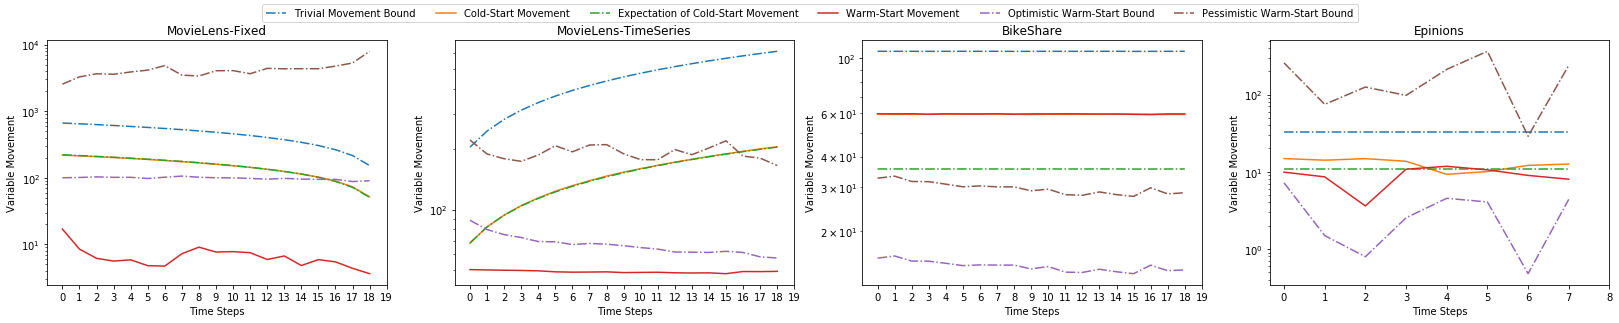

In [578]:
# Variable movement graph
fig, axs = plt.subplots(1, 4, figsize=(28, 4.5))
i = 0
for dataset in ["movielens-1m", "bikeshare", "epinions"]:
    for experiment in EXPERIMENTS[dataset]:
        experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
        try:
            atom_run_df = pd.DataFrame()
            random_run_df = pd.DataFrame()
            for fold in os.listdir(experiment_path):
                # :(
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    atom_psl_version = "online"
                    random_psl_version = "offline"
                    if dataset == "epinions":
                        atom_method = "NON_POWERSET"
                        random_method = "SGD_TI"
                    else:
                        atom_method = "POWERSET"
                        random_method = "SGD_TI"
                    atom_initialization = "ATOM"
                    random_initialization = "RANDOM"
                
                    atom_run_path = os.path.join(experiment_path, fold, atom_psl_version, atom_method, atom_initialization)
                    random_run_path = os.path.join(experiment_path, fold, random_psl_version, random_method, random_initialization)
                    atom_run_df = atom_run_df.append(pd.read_csv(os.path.join(atom_run_path, "run.csv")), ignore_index=True)
                    random_run_df = random_run_df.append(pd.read_csv(os.path.join(random_run_path, "run.csv")), ignore_index=True)
                    
            axs[i].set_title(EXPERIMENT_TITLES[experiment])
            
            # plot using atom run alphas and all bounds
            plot_data(axs[i],
                      atom_run_df.time_step.unique()[1:], 
                      [np.sqrt(atom_run_df.groupby("time_step").num_inferred.mean())[1:], 
                       random_run_df.groupby("time_step").var_movement.mean()[1:],
                       (np.sqrt(atom_run_df.groupby("time_step").num_inferred.mean()) / 3)[1:],
                       atom_run_df.groupby("time_step").var_movement.mean()[1:],
                       ((2 * atom_run_df.groupby("time_step").beta_max.mean() / 
                        ((atom_run_df.groupby("time_step").beta_avg.mean()))) * 
                       atom_run_df.groupby("time_step").var_delta.mean() + 
                       (2 / ((atom_run_df.groupby("time_step").beta_avg.mean()))) * 
                       atom_run_df.groupby("time_step").delta_model_grad_mag.mean())[1:],
                       ((2 * atom_run_df.groupby("time_step").beta_max.mean() / 
                        ((atom_run_df.groupby("time_step").alpha_min.mean() + 0.1) / 2)) * 
                       atom_run_df.groupby("time_step").var_delta.mean() + 
                       (2 / ((atom_run_df.groupby("time_step").alpha_min.mean() + 0.1) / 2)) * 
                       atom_run_df.groupby("time_step").delta_model_grad_mag.mean())[1:]], 
                      "Time Steps", "Variable Movement", 
                      ["Trivial Movement Bound", "Cold-Start Movement", "Expectation of Cold-Start Movement", 
                       "Warm-Start Movement", "Optimistic Warm-Start Bound", "Pessimistic Warm-Start Bound"],
                      ["-.", "-", "-.", "-", "-.", "-."],
                      log=True)
            i += 1
        
        except FileNotFoundError as err:
            print(err)
            continue
            
lines, labels = axs[-2].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper center", ncol=len(labels))
plt.savefig("stability_empirical.png")
plt.show()

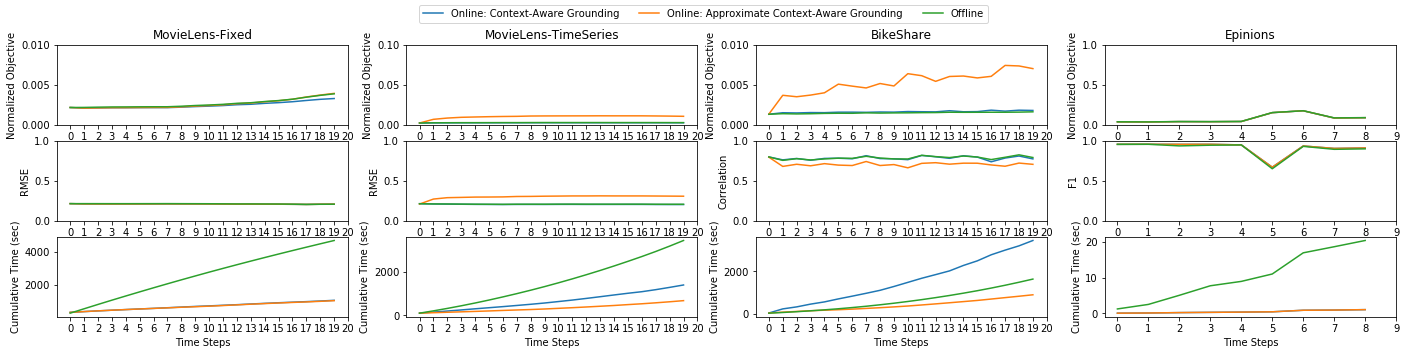

In [579]:
# Timing Graph
fig, axs = plt.subplots(3, 4, figsize=(24, 5), sharex=False)
i = 0
for dataset in ["movielens-1m", "bikeshare", "epinions"]:
    for experiment in EXPERIMENTS[dataset]:
        experiment_path = os.path.join(BASE_RESULTS_DIR, dataset, experiment) 
        try:
            online_powerset_run_df = pd.DataFrame()
            online_non_powerset_run_df = pd.DataFrame()
            offline_run_df = pd.DataFrame()
            for fold in os.listdir(experiment_path):
                # :(
                if (fold != ".ipynb_checkpoints") and (fold != "results.csv"):
                    online_psl_version = "online"
                    offline_psl_version = "offline"
                    online_initialization = "ATOM"
                    offline_initialization = "RANDOM"
                
                    if dataset == "epinions":
                        online_powerset_run_path = os.path.join(
                            experiment_path, fold, online_psl_version, "NON_POWERSET", online_initialization)
                    else:
                        online_powerset_run_path = os.path.join(
                            experiment_path, fold, online_psl_version, "POWERSET", online_initialization)
                    online_non_powerset_run_path = os.path.join(
                        experiment_path, fold, online_psl_version, "NON_POWERSET", online_initialization)
                    offline_run_path = os.path.join(
                        experiment_path, fold, offline_psl_version, "SGD_TI", offline_initialization)
                    
#                     print(online_powerset_run_path)
#                     print(online_non_powerset_run_path)
#                     print(offline_run_path)
                    try:
                        online_powerset_run_df = online_powerset_run_df.append(
                            pd.read_csv(os.path.join(online_powerset_run_path, "run.csv")), ignore_index=True)
                        online_non_powerset_run_df = online_non_powerset_run_df.append(
                            pd.read_csv(os.path.join(online_non_powerset_run_path, "run.csv")), ignore_index=True)
#                         print(online_non_powerset_run_df.loc[online_non_powerset_run_df.time_step==10.0][["time_step", "full_norm_obj"]])
                        offline_run_df = offline_run_df.append(
                            pd.read_csv(os.path.join(offline_run_path, "run.csv")), ignore_index=True)
                    except pd.io.common.EmptyDataError as err:
                        print(err)
                        continue
            
            # Plot Time Information
            online_powerset_accumulated_time = online_powerset_run_df.groupby("time_step").time.mean().cumsum() / 1000
            online_non_powerset_accumulated_time = online_non_powerset_run_df.groupby("time_step").time.mean().cumsum()  / 1000
            offline_accumulated_time = offline_run_df.groupby("time_step").time.mean().cumsum() / 1000
            axs[0, i].set_title(EXPERIMENT_TITLES[experiment])
            plot_data(axs[2, i], online_powerset_run_df.time_step.unique(), 
                      [online_powerset_accumulated_time, 
                       online_non_powerset_accumulated_time,
                       offline_accumulated_time], 
                      "Time Steps", "Cumulative Time (sec)", 
                      ["Online: Context-Aware Grounding", 
                       "Online: Approximate Context-Aware Grounding", 
                       "Offline"], 
                      ["-", "-", "-"],
                      log=False) 
            # Plot Evalutaion Information
            axs[1, i].set_ylim([0, 1])
            plot_data(axs[1, i], online_powerset_run_df.time_step.unique(), 
                      [online_powerset_run_df.groupby("time_step").evaluation.mean(), 
                       online_non_powerset_run_df.groupby("time_step").evaluation.mean(),
                       offline_run_df.groupby("time_step").evaluation.mean()], 
                      "Time Steps", EVALUATOR_NAME[experiment], 
                      ["Online: Context-Aware Grounding", 
                       "Online: Approximate Context-Aware Grounding",
                       "Offline"], 
                      ["-", "-", "-"],
                      log=False)
            # Plot Final Obj Information
            plot_data(axs[0, i], online_powerset_run_df.time_step.unique(), 
                      [online_powerset_run_df.groupby("time_step").full_norm_obj.mean(),
                       online_non_powerset_run_df.groupby("time_step").full_norm_obj.mean(),
                       offline_run_df.groupby("time_step").full_norm_obj.mean()], 
                      "Time Steps", "Normalized Objective", 
                      ["Online: Context-Aware Grounding",
                       "Online: Approximate Context-Aware Grounding",
                       "Offline"], 
                      ["-", "-", "-"],
                      y_lim=EXPERIMENT_YLIMS[experiment],
                      log=False)
            i += 1
            
        except FileNotFoundError as err:
            print(err)
            continue
    
lines, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper center", ncol=len(labels))
plt.savefig("performance_empirical.png")
plt.show()